In [358]:
import numpy as np
import random
import matplotlib.pyplot as plt
%config IPCompleter.greedy=True 

# Left 20%, Right 80%

suppose the probability distribution of getting reward is constant.

only two choise, left or right.

there would be no states but the learning change would be marked by time

the randomness of exploring instead of always choose the maximum expectation is modelled by sigmoid function, which makes such randomness constantly changing along time

# Todo: add in more policies

In [828]:
# some constants
obs_size = 2 # get 0 or 1 as reward
action_size = 2 #turn left or right
alpha = 0.2 #learning rate
beta = 4 # sharpness of sigmoid; this could be dynamic
gamma = 0
iteration = 80000
every_it_print=1000

# Env Policy
left = 0.2 # probablity of reward in left
right = 1 - left # probability of reward in right

In [829]:
# sigmoid function for nd; return the value of sigmoid with argument beta
# q can be n dimensional, either list or int/float
# beta should be between 0 and 1; determine the sharpness of sigmoid
# we can also try different functions here
def sigmoid(beta,q):
    q=np.array(q)
    val = 1/(1+np.exp(0-beta*q))
    return val
def ratchose(Q): # 0 means left
    if random.uniform(0,1)<sigmoid(beta,Q[0]-Q[1]):
        return np.array([1,0])
    else:
        return np.array([0,1])

In [859]:
# Experiment
# reward = (1,0) represent reward is on the left, (0,1) right
# turn = (1,0) represent rat is on the left, (0,1) right

l_rat = 0.5 # evaluation from rat on how likely the reward is on left
r_rat = 0.5 # that for right
reward_rat = 0 # reward got by rat by last action; = reward
exp = 0 # action that maximize reward; 0 for left, 1 for right

count = 0 # count for continuous success of choosing the advantageous action(here, the right)
Q = np.zeros(2)

#logs
rewards=[]
Qlog=[]
temp=[]

for i in range(iteration):
            
    # 0. get choice from rat 
    
    turn = ratchose(Q)

    # 0. set reward 
    reward_site = random.uniform(0,1)
    if reward_site < right and np.array_equal(turn,np.array([0,1])):
    #if the rat goes right and the reward is on the right
        reward = np.array((0,1))
    elif reward_site >= right and np.array_equal(turn,np.array([1,0])):
        reward = np.array((1,0))
    else:
        reward=np.array((0,0))
    rewards.append(reward)
    
    # 2. update rat's information 
    # Q will be between 0 and 5
    Q = Q + alpha*turn*(reward + gamma*np.max(Q)-Q) # I think this is where it went wrong
    Qlog.append(Q)
    # you should only update the action taken

#     l_rat = 1-(sigmoid(beta,Q[0])/(sigmoid(beta,Q[0])+sigmoid(beta,Q[1])))
#     r_rat=1-l_rat
    ratchose(Q)
    
    # I changed this function
    # 3. update count
    if np.array_equal(turn,np.array([1,0])):
        count = 0
    elif np.array_equal(turn,np.array([0,1])):
        count = count + 1
        
        
    # Show ongoing results
    if i%every_it_print==0:
#         print('Q-table',Q)
#         print(l_rat)
        #print(Q,reward)
        print(np.mean(np.array(Qlog)[:,0]))
        
        temp.append(np.mean(np.array(Qlog)[:,0]))


    # end experiment if rat made more than 10 times right turn, which has prob < 0.00098 by purely random choice
#     if i == 280: #abs(r_rat-right < 0.01) # count > 10
#         print('The rat might has learned somthing. Iteration number:')
#         print(Q)

#         break

0.0
0.09032296633956527
0.12279660525795823
0.1373957855315409
0.1502537506122464
0.1492883071249338
0.1516962300150705
0.15427162262820407
0.1546636847398702
0.1524040844407078
0.15984498866642696
0.16047233505474784
0.153446313508175
0.15309000697985206
0.14880768406874725
0.14750305397003005
0.14861043939762406
0.14727024397887256
0.14994857847139118
0.14878674836567513
0.14852653020162077
0.14966319790868315
0.1477321848732051
0.1501233126003398
0.1484873790405291
0.1500671955178424
0.15061555744394792
0.14832771096350622
0.15027850009410848
0.146877862203265
0.14786536133138156
0.14900530637796058
0.1497526032460074
0.14914171556281808
0.14935170740847972
0.15042176534772478
0.1495837880377017
0.15163767835067116
0.151324491296284
0.14990108423829687
0.1500712255362356
0.15011376771045648
0.15137360949471135
0.15084610099076465
0.1513026668780398
0.1517340673648824
0.15055007060798153
0.15167445632818508
0.15279939549825897
0.15218038476780407
0.15276695352190828
0.153126013405768

# Varience

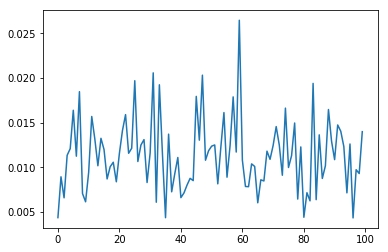

In [878]:
out=[]
chulks=100
for i in range(chulks):
    out.append(np.var(np.array(Qlog)[int(i*len(Qlog)/chulks):int((i+1)*len(Qlog)/chulks),0]))
plt.plot(out)

# The expectation 

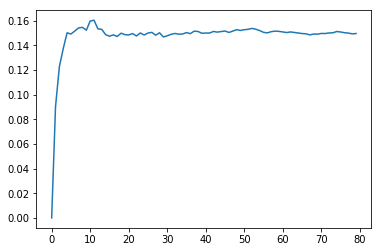

In [860]:
plt.plot()

In [407]:
1-(sigmoid(beta,0.8)/(sigmoid(beta,0.8)+sigmoid(beta,0.2)))

0.9659378796930785

In [247]:
env=[0.2,0.8]
train_size=5000
def get_reward(action,env): # 0 when reward is on the left
    if np.random.uniform(0,1)<env[1]:
        return int(action==1)
    else:
        return int(action==0)
def get_action(Q):
    return np.argmax(Q)

In [325]:
# second implementation
actions = np.array([0,1]) # 0 for left, 1 for right
Q = np.random.uniform(low=0,high=1,size=(action_size))
for i in range(train_size):
    action=get_action(Q)
    reward=get_reward(action,env)
    Q[action]=(1-alpha)*Q[action]+alpha*(reward+gamma*np.max(Q))
print(Q)

[2.37357591e-01 7.98636218e+02]


# Trying a different implementation

In [684]:
class toyQ_2choice:
    '''a unchanging env with probability of giving one
    of two rewards based on params to two different choices'''
    obs_size=1
    action_size=2
    def __init__(self,left=0.2,right=0.8):
        self.left=left
        self.right=right
    def step(self,action,state=None):
        '''takes in the action param as a int of 0 or 1
        where 0 is go left and 1 is to right, and returns
        a return_site where 0 is left and 1 is right'''
        reward_site=int(random.uniform(0,1)<self.right)
        return int(reward_site==action)
    
class WSLS_rat: # to-do
    pass

class sig_rat:
    def __init__(self,env,beta=-4,gamma=0):
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.beta=beta
        self.env=env
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self):
        
        pass
    


In [682]:
np.zeros((4,)+(2,))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [689]:
env=toyQ_2choice()
rat=sig_rat(env)
print(rat.Q)

[[0. 0.]]


In [ ]:
# some constants
obs_size = 2 # get 0 or 1 as reward
action_size = 2 #turn left or right
alpha = 0.2 #learning rate
beta = -6 # sharpness of sigmoid; this could be dynamic
gamma = 0
iteration = 80000
every_it_print=1000

# Env Policy
left = 0.2 # probablity of reward in left
right = 1 - left # probability of reward in right